# EfficientNetB4 – Cleaned Notebook (organized for training vs inference)


- Model has been trained + saved a checkpoint, you only need to run the cells marked **(INFERENCE-ONLY)**.
- Training cells are clearly marked **(TRAINING)**.

> Original notebook: `EfficientNetB4 (1).ipynb`  



## 0. Setup (RUN)
Run the imports + environment setup once per kernel restart.

In [2]:
import os
import zipfile
import random
import shutil

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

import timm

from PIL import Image
from torchvision import transforms, datasets
import torchvision.transforms.functional as F

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

from io import BytesIO

import torch, os


## 1. Data paths + load 2020 training metadata (RUN)

In [3]:
DATASET_PATH = "/home/arvoskanian/teams/z16/data"

TRAIN_IMAGES_ZIP = os.path.join(DATASET_PATH, "ISIC_2020_Training_JPEG.zip")
TRAIN_METADATA_PATH = os.path.join(DATASET_PATH, "ISIC_2020_Training_Metadata.csv")

df = pd.read_csv(TRAIN_METADATA_PATH)

print(df.shape)
print(df['target'].value_counts())

(33126, 8)
target
0    32542
1      584
Name: count, dtype: int64


In [4]:

with zipfile.ZipFile(TRAIN_IMAGES_ZIP, 'r') as z:
    all_files = z.namelist()

print("Number of images in ZIP:", len(all_files))
print("First 10 filenames:", all_files[:10])

Number of images in ZIP: 33127
First 10 filenames: ['train/', 'train/ISIC_1260198.jpg', 'train/ISIC_9893956.jpg', 'train/ISIC_4619903.jpg', 'train/ISIC_9706782.jpg', 'train/ISIC_2021321.jpg', 'train/ISIC_2631789.jpg', 'train/ISIC_1807319.jpg', 'train/ISIC_8369671.jpg', 'train/ISIC_6762061.jpg']


## 2. Train/Val split (RUN)

### Data Split Summary

- Performed an 80/20 train–validation split with `train_test_split`, stratifying on `target` to maintain class balance across both sets.
- Used random seed **42**, matching the ResNet model configuration so our splits align for the ensemble we’re building.
- Reset indices on both `train_df` and `val_df` after splitting to ensure contiguous indexing.
- Verified and printed the shapes and class counts of the train and validation sets to confirm the stratified distribution (actual counts depend on the dataset).

In [5]:

SEED = 42  # match ResNet notebook
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["target"],
    random_state=SEED
)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("\nTrain class counts:\n", train_df["target"].value_counts())
print("\nVal class counts:\n", val_df["target"].value_counts())

Train: (26500, 8)
Val: (6626, 8)

Train class counts:
 target
0    26033
1      467
Name: count, dtype: int64

Val class counts:
 target
0    6509
1     117
Name: count, dtype: int64


In [6]:
len(set(train_df['patient_id']).intersection(set(val_df['patient_id'])))

1704

## 3. Transforms (RUN)

### Image Preprocessing Summary

- **Custom ResizeWithPadding (size=380)**
  - EfficientNet recommends images are 380x380 pixels
  - Rescales each image so its longest side becomes 380 px while preserving aspect ratio.  
  - Pads the resized image with zeros, black padding, to reach an exact 380 × 380 canvas, keeping content centered.

- **Training Transform Pipeline**
  1. Run `ResizeWithPadding(380)`
  2. Random horizontal and vertical flips for data augmentation.
  3. Conversion to tensor (`ToTensor`).
  4. Normalization with ImageNet mean `[0.485, 0.456, 0.406]` and std `[0.229, 0.224, 0.225]`.

- **Validation Transform Pipeline**
  1. `ResizeWithPadding(380)`
  2. `ToTensor`
  3. Same ImageNet normalization to match training distribution.
  4. We don't need to introduce random flipping or color augumentations

- **Purpose**: Ensure consistent 380 × 380 inputs for the ensemble components (including the ResNet branch) while augmenting only the training data to improve generalization.


In [7]:
class ResizeWithPadding:
    def __init__(self, size=380):
        self.size = size

    def __call__(self, img):
        w, h = img.size
        scale = self.size / max(w, h)
        nw, nh = int(w * scale), int(h * scale)
        img = F.resize(img, (nh, nw))

        pad_w = self.size - nw
        pad_h = self.size - nh

        padding = (
            pad_w // 2, pad_h // 2,
            pad_w - pad_w // 2, pad_h - pad_h // 2
        )

        return F.pad(img, padding, fill=0)

In [8]:
train_transform = transforms.Compose([
    ResizeWithPadding(380),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    ResizeWithPadding(380),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

## 4. Dataset class (RUN)

## ISICZipDataset Overview

- Wraps a dataframe plus a zipped image archive to behave like a PyTorch `Dataset`.
- Resets the dataframe index for consistent lookup and stores an optional transform.
- `__len__`: returns the number of rows in the dataframe -> total samples.
- `__getitem__(idx)` workflow:
  1. Locates the row at `idx` and constructs `train/{image_name}.jpg`.
  2. Opens that file directly from the ZIP without extracting to disk, converting to RGB.
  3. Applies the provided transform if present.
  4. Returns the processed image tensor and the corresponding target as a `torch.float32`.

- **Purpose**: Efficiently stream ISIC images from a ZIP file while keeping labels synchronized for training/validation pipelines.

In [9]:
class ISICZipDataset(Dataset):
    def __init__(self, dataframe, zip_path, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.zip_path = zip_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Add folder and extension
        filename = f"train/{row['image_name']}.jpg"  

        with zipfile.ZipFile(self.zip_path, 'r') as z:
            with z.open(filename) as f:
                image = Image.open(f).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(row['target'], dtype=torch.float32)

## 5. Build datasets + dataloaders (TRAINING / optional for inference)

### Dataset & DataLoader Setup

- **Datasets**
  - `train_dataset` and `val_dataset` both use `ISICZipDataset`, pointing to the same ZIP archive (`TRAIN_IMAGES_ZIP`) but fed different data frames (`train_df`, `val_df`) and transforms (`train_transform`, `val_transform`).

- **DataLoaders**
  - `train_loader`: batch size 16, shuffles data each epoch, uses 4 workers with pinned, persistent worker processes for efficient throughput.
  - `val_loader`: batch size 16, no shuffling (deterministic evaluation), same worker/pinning configuration as training.

- **Purpose**: Provide efficient, consistent streaming of augmented training batches and standardized validation batches for our ensemble pipeline.

In [10]:
train_dataset = ISICZipDataset(train_df, TRAIN_IMAGES_ZIP, transform=train_transform)
val_dataset   = ISICZipDataset(val_df,   TRAIN_IMAGES_ZIP, transform=val_transform)

In [11]:
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

## 6. Device + model definition (RUN)

## Model Initialization

- **Device selection**: Chooses CUDA if available, otherwise CPU, and reports the choice for reproducibility. Ideally we want to leverage GPU for training.
- **Backbone**: Loads a pretrained `efficientnet_b4` from `timm`.
- **Head modification**: Replaces the original classifier with a single-output `nn.Linear` layer to support binary classification.
- **Deployment**: Moves the entire model to the selected device, preparing it for training/inference alongside the ResNet component in the ensemble.

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [13]:
model = timm.create_model("efficientnet_b4", pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 1)  # binary classification
model = model.to(device)

## 7. Loss / optimizer / scaler (RUN)

### Loss, Optimizer, and Scaling Setup

- **Class weights**: Computed balanced weights for classes `[0, 1]` using `train_df['target']`, then converted the positive-class weight into a CUDA/CPU tensor (`pos_weight`) to address class imbalance.
- **Loss function**: `nn.BCEWithLogitsLoss` with `pos_weight` to penalize positive examples proportionally more when they are underrepresented.
- **Optimizer**: Adam over all model parameters with a learning rate of `1e-4`.
- **Mixed precision**: `GradScaler()` initialized for automatic mixed-precision training, improving numerical stability and throughput on GPU.

In [14]:
classes = np.array([0, 1])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['target'])
pos_weight = torch.tensor(weights[1], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()

## 8. Training loop + checkpointing (TRAINING)

## Training & Checkpointing Workflow

- **Checkpoint infrastructure**
  - Due to remote compute timeouts, incorporated checkpointing so that we could resume training epochs.
  - Creates a `checkpoints/` folder with two targets: `effb4_last.pt` (latest state) and `effb4_best.pt` (best validation ROC-AUC).

- **Validation metric**
  - `evaluate_auc` runs the model in eval mode, gathers sigmoid probabilities, and computes ROC-AUC.

- **Training loop (10 epochs)**
  - Resumes from `effb4_last.pt` if available
  - For each epoch:
    1. Switches to train mode and iterates over `train_loader`.
    2. Moves data to the selected device, casts labels to `(B, 1)`.
    3. Uses mixed precision (`autocast` + `GradScaler`) to compute loss (`BCEWithLogitsLoss`), backprop, and update with Adam.
    4. Tracks average training loss, then evaluates ROC-AUC on the validation loader.

- **Model persistence**
  - Always saves the “last” checkpoint every epoch.
  - Updates the “best” checkpoint only when the new validation AUC beats the previous best (ignoring NaNs), announcing improvements for traceability.

In [ ]:

os.makedirs("checkpoints", exist_ok=True)
CKPT_LAST = "checkpoints/effb4_last.pt"
CKPT_BEST = "checkpoints/effb4_best.pt"

def save_checkpoint(path, model, optimizer, scaler, epoch, best_auc):
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
        "epoch": epoch,              # last completed epoch index
        "best_auc": best_auc
    }, path)

def load_checkpoint(path, model, optimizer=None, scaler=None, device="cpu"):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    if optimizer is not None and "optimizer_state" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer_state"])
    if scaler is not None and "scaler_state" in ckpt and ckpt["scaler_state"] is not None:
        scaler.load_state_dict(ckpt["scaler_state"])
    start_epoch = ckpt.get("epoch", -1) + 1
    best_auc = ckpt.get("best_auc", -1.0)
    return start_epoch, best_auc

def evaluate_auc(loader):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.numpy().astype(float).tolist()

            logits = model(images)
            probs = torch.sigmoid(logits).squeeze(1).detach().cpu().numpy().tolist()

            all_probs.extend(probs)
            all_labels.extend(labels)

    # If a weird edge case happens where val has only one class (rare w/ stratify), handle safely
    if len(set(all_labels)) < 2:
        return float("nan")
    return roc_auc_score(all_labels, all_probs)

num_epochs = 10

# Resume if last checkpoint exists
start_epoch = 0
best_auc = -1.0
if os.path.exists(CKPT_LAST):
    start_epoch, best_auc = load_checkpoint(CKPT_LAST, model, optimizer, scaler, device=device)
    print(f"Resuming from {CKPT_LAST} at epoch {start_epoch}, best_auc={best_auc:.4f}")

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.unsqueeze(1).to(device)  # shape (B,1)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(images)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / max(1, len(train_loader))
    val_auc = evaluate_auc(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f} - Val ROC-AUC: {val_auc:.4f}")

    # Always save "last"
    save_checkpoint(CKPT_LAST, model, optimizer, scaler, epoch, best_auc)

    # Save "best" if improved (ignore nan AUC)
    if not np.isnan(val_auc) and val_auc > best_auc:
        best_auc = val_auc
        save_checkpoint(CKPT_BEST, model, optimizer, scaler, epoch, best_auc)
        print(f"  ✅ New best AUC! Saved to {CKPT_BEST} (best_auc={best_auc:.4f})")



**Epoch 1/10** - Loss: 0.7053 - Val ROC-AUC: 0.8912
  ✅ New best AUC! Saved to checkpoints/effb4_best.pt (best_auc=0.8912)
**Epoch 2/10** - Loss: 0.5148 - Val ROC-AUC: 0.8880
**Epoch 3/10** - Loss: 0.3970 - Val ROC-AUC: 0.8940
  ✅ New best AUC! Saved to checkpoints/effb4_best.pt (best_auc=0.8940)
**Epoch 4/10** - Loss: 0.3160 - Val ROC-AUC: 0.8820
**Epoch 5/10** - Loss: 0.2292 - Val ROC-AUC: 0.8795
**Epoch 6/10** - Loss: 0.1691 - Val ROC-AUC: 0.8819
**Epoch 7/10** - Loss: 0.1550 - Val ROC-AUC: 0.8631
**Epoch 8/10** - Loss: 0.1657 - Val ROC-AUC: 0.9085
  ✅ New best AUC! Saved to checkpoints/effb4_best.pt (best_auc=0.9085)
**Epoch 9/10** - Loss: 0.1276 - Val ROC-AUC: 0.8730

## 9. Post-training validation analysis (OPTIONAL)

### Validation Artifact Inspection

1. **Load predictions and sanity-check the file system**
   - Loads `artifacts/val_probs_efficientnet_b4.npy` (model-predicted probabilities) and prints shape, a sample of values, and min/max to ensure the array looks valid.

2. **Load labels and cross-validate lengths**
   - Loads `artifacts/val_labels_e.npy` (ground-truth targets) and inspects shape and the set of unique labels to confirm it’s binary.
   - Confirms `len(probs) == len(labels)` and matches the `val_dataset` length, guarding against misalignment between predictions and labels.

3. **Class distribution analysis**
   - Computes total counts, malignant/benign totals, and malignant rate to quantify class balance in the validation set.

4. **Probability statistics**
   - Prints overall mean, median, and standard deviation of the probabilities.
   - Splits probabilities by class (benign vs. malignant) and reports class-specific means and medians. Higher malignant probabilities compared to benign ones indicate the model is discriminating as expected.

In [16]:
probs = np.load("artifacts/val_probs_efficientnet_b4.npy")
print("Shape:", probs.shape)
print("First 10 probs:", probs[:10])
print("Min/Max:", probs.min(), probs.max())

Shape: (6626,)
First 10 probs: [5.0199468e-04 2.7572500e-02 1.2731420e-04 5.1566881e-06 7.6574783e-05
 6.2497907e-05 1.2249166e-05 5.8875149e-03 9.0434687e-06 7.7124441e-04]
Min/Max: 4.0975614e-09 0.99826753


In [17]:
import os
print("CWD:", os.getcwd())
print("artifacts exists?", os.path.exists("artifacts"))
if os.path.exists("artifacts"):
    print(os.listdir("artifacts")[:50])


CWD: /home/arvoskanian/teams/z16/data
artifacts exists? True
['test_probs_efficientnet_b4_2019.npy', 'labels_sample3000.npy', 'labels_sample1000.npy', 'val_probs_efficientnet_b4.npy', 'val_labels_e.npy', '.ipynb_checkpoints', 'features_sample3000.parquet', 'features_sample1000.parquet']


In [18]:
labels = np.load("artifacts/val_labels_e.npy")
print("Shape:", labels.shape)
print("First 10 labels:", labels[:10])
print("Unique labels:", set(labels))

Shape: (6626,)
First 10 labels: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Unique labels: {0.0, 1.0}


In [19]:
len(probs) == len(labels)

True

In [20]:
print("len(probs):", len(probs))
print("len(labels):", len(labels))

len(probs): 6626
len(labels): 6626


In [21]:
print("len(val_dataset):", len(val_dataset))

len(val_dataset): 6626


In [22]:
len(probs) == len(labels)

True

In [23]:

print("Total samples:", len(probs))
print("Malignant count:", int(np.sum(labels)))
print("Benign count:", int(len(labels) - np.sum(labels)))
print("Malignant rate:", np.mean(labels))

print("\nProbability summary:")
print("Mean prob:", np.mean(probs))
print("Median prob:", np.median(probs))
print("Std prob:", np.std(probs))

Total samples: 6626
Malignant count: 117
Benign count: 6509
Malignant rate: 0.017657712

Probability summary:
Mean prob: 0.06354138
Median prob: 0.0004398788
Std prob: 0.18081005


In [24]:
benign_probs = probs[labels == 0]
malignant_probs = probs[labels == 1]

print("Benign mean prob:", benign_probs.mean())
print("Malignant mean prob:", malignant_probs.mean())

print("Benign median prob:", np.median(benign_probs))
print("Malignant median prob:", np.median(malignant_probs))

Benign mean prob: 0.056038592
Malignant mean prob: 0.4809404
Benign median prob: 0.0004000432
Malignant median prob: 0.45749688


# 10. Load best Epoch

In [25]:
# ---- Load BEST checkpoint (EffNetB4) for evaluation/inference ----


CKPT_BEST = "checkpoints/effb4_best.pt"
assert os.path.exists(CKPT_BEST), f"Missing checkpoint: {CKPT_BEST}"

ckpt = torch.load(CKPT_BEST, map_location="cpu")

# This prints missing/unexpected keys if something doesn't match
incompat = model.load_state_dict(ckpt["model_state"], strict=True)
print("Loaded CKPT_BEST. strict=True passed.")
print("Checkpoint epoch:", ckpt.get("epoch"), "best_auc:", ckpt.get("best_auc"))

model = model.to(device)
model.eval()


Loaded CKPT_BEST. strict=True passed.
Checkpoint epoch: 7 best_auc: 0.9084961913353371


EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [26]:
print("Loaded checkpoint epoch:", ckpt.get("epoch"))
print("Best val AUC in checkpoint:", ckpt.get("best_auc"))


Loaded checkpoint epoch: 7
Best val AUC in checkpoint: 0.9084961913353371


## 11. 2019 Test inference (INFERENCE-ONLY)

### 2019 Test Evaluation

1. **Dataset prep**
   - Defined paths for the 2019 ISIC test ZIP, metadata, ground truth, and internal folder name.
   - `SkinLesionTestDataset` streams RGB images directly from the ZIP, using IDs from the metadata CSV (expects an `"image"` column). Applies the EfficientNet validation transform (`val_transform`) for consistent 380 × 380 preprocessing.

2. **Loader configuration**
   - `test_loader`: batch size 32, deterministic order (`shuffle=False`), and 4 workers with pinned, persistent workers for throughput.

3. **Model inference**
   - Ensures `artifacts/` exists, switches the EfficientNet-B4 model to eval mode, and disables gradients.
   - Iterates over `test_loader`, runs forward passes, converts logits to sigmoid probabilities, accumulates them, and saves the concatenated array (`float32`) to `artifacts/test_probs_efficientnet_b4_2019.npy`.

4. **Evaluation against ground truth**
   - Loads `ISIC_2019_Test_GroundTruth.csv`, extracts binary MEL labels, and computes ROC-AUC to quantify discrimination performance.
   - Thresholds probabilities at 0.5 to derive class predictions, then prints the confusion matrix `[[TN, FP], [FN, TP]]` for granular error analysis.

5. **Purpose**:  Generates and archives EfficientNet-B4 predictions on the 2019 test set, providing both raw probabilities for ensemble blending and standalone performance metrics (AUC + confusion matrix).


In [27]:
TEST_2019_ZIP = "./2019_test/ISIC_2019_Test_Input.zip"
TEST_2019_METADATA = "./2019_test/ISIC_2019_Test_Metadata.csv"
TEST_2019_GT = "./2019_test/ISIC_2019_Test_GroundTruth.csv"
TEST_2019_FOLDER_IN_ZIP = "ISIC_2019_Test_Input"


In [28]:

class SkinLesionTestDataset(Dataset):
    def __init__(self, dataframe, zip_path, folder_name, transform=None, image_col="image"):
        self.df = dataframe.reset_index(drop=True)
        self.zip_path = zip_path
        self.folder_name = folder_name
        self.transform = transform
        self.image_col = image_col

        # ResNet-style: metadata has image id without ".jpg"
        if self.image_col not in self.df.columns:
            raise ValueError(f"Expected column '{self.image_col}' in metadata. Columns: {self.df.columns.tolist()}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx][self.image_col]
        img_path = f"{self.folder_name}/{image_id}.jpg"
        with zipfile.ZipFile(self.zip_path, "r") as z:
            with z.open(img_path) as f:
                img = Image.open(BytesIO(f.read())).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img


In [29]:


test_metadata = pd.read_csv(TEST_2019_METADATA)

test_dataset = SkinLesionTestDataset(
    dataframe=test_metadata,
    zip_path=TEST_2019_ZIP,
    folder_name=TEST_2019_FOLDER_IN_ZIP,
    transform=val_transform,   # <-- your EfficientNet validation/test transform at 380
    image_col="image"
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)


In [30]:


os.makedirs("artifacts", exist_ok=True)

model.eval()
all_probs = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits).view(-1)
        all_probs.append(probs.detach().cpu().numpy())

test_probs_e = np.concatenate(all_probs).astype(np.float32)

np.save("artifacts/test_probs_efficientnet_b4_2019.npy", test_probs_e)
print("Saved:", "artifacts/test_probs_efficientnet_b4_2019.npy", "shape:", test_probs_e.shape)


Saved: artifacts/test_probs_efficientnet_b4_2019.npy shape: (8238,)


In [31]:


gt = pd.read_csv(TEST_2019_GT)
y_true = gt["MEL"].values.astype(int)

auc = roc_auc_score(y_true, test_probs_e)
print("EffNetB4 2019 AUC:", auc)

y_pred = (test_probs_e >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix [[TN FP],[FN TP]]:\n", cm)


EffNetB4 2019 AUC: 0.7023456920299073
Confusion Matrix [[TN FP],[FN TP]]:
 [[3011 3900]
 [ 256 1071]]


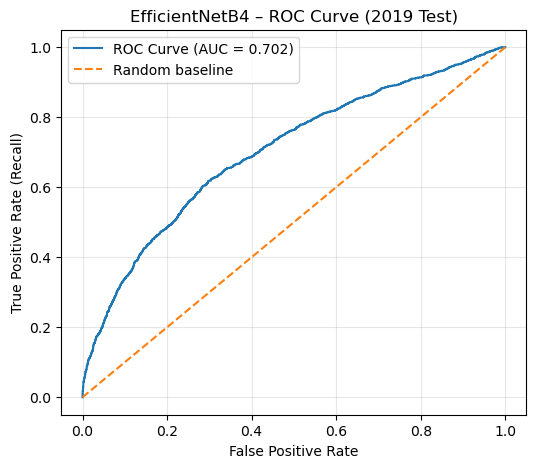

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, test_probs_e)

# Compute ROC-AUC
roc_auc = roc_auc_score(y_true, test_probs_e)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', label='Random baseline')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("EfficientNetB4 – ROC Curve (2019 Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [32]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

# y_true: 0/1 ground-truth labels (MEL)
# test_probs_e: predicted probabilities from EfficientNet (sigmoid outputs)

# (1) Average Precision (most common "PR-AUC" people report)
ap = average_precision_score(y_true, test_probs_e)

# (2) Area under the PR curve via trapezoidal rule (often close to AP, not always identical)
precision, recall, thresholds = precision_recall_curve(y_true, test_probs_e)
pr_auc_trapz = auc(recall, precision)

# Baseline PR-AUC if you guessed positive at random is just the positive rate
pos_rate = y_true.mean()

print(f"EffNetB4 2019 Average Precision (PR-AUC): {ap:.6f}")
print(f"EffNetB4 2019 PR-AUC (trapz):             {pr_auc_trapz:.6f}")
print(f"Positive rate baseline (random):          {pos_rate:.6f}")

EffNetB4 2019 Average Precision (PR-AUC): 0.359394
EffNetB4 2019 PR-AUC (trapz):             0.359035
Positive rate baseline (random):          0.161083


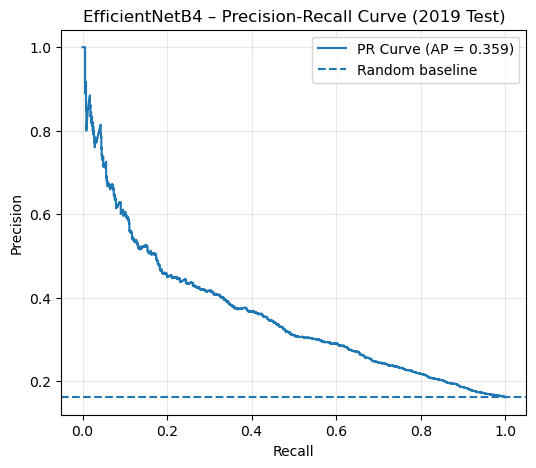

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, test_probs_e)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap:.3f})')
plt.axhline(y=y_true.mean(), linestyle='--', label='Random baseline')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("EfficientNetB4 – Precision-Recall Curve (2019 Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()